In [2]:
import sys
import os
import ctypes
import copy


# Get the absolute path of the utils directory
utils_path = os.path.abspath("../lib")
sys.path.append(utils_path)
%load_ext autoreload
%autoreload 2

In [5]:
from qiskit_nature.second_q.circuit.library.ansatzes.ucc import UCC
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_nature.second_q.mappers import JordanWignerMapper
from custom_UCC import custom_UCC

import matplotlib.pyplot as plt
import numpy as np
import qiskit.qpy as qpy
import pickle
import json
import matplotlib.patches as mpatches
from numba import njit
from numba.typed import List
from plotting import *
from readings import *
from tile_process import *
from double_pack import *
import random

In [6]:
seam_lst = [8,16]
prehead = "../../H_12_cluster/"
f_orbs = (2,2,2,2,2,2)
read_epsilon = 1.0
distance = 3.0
epsilon = 1e-4
epsilon_lst = np.linspace(4.1,4.5,5)
print(epsilon_lst)
epsilon_lst = 10**-(epsilon_lst)
ratio_lst = np.linspace(1, 15, 15)
read_epsilon = 1.0
uop, all_g = read_uop(distance, read_epsilon, prehead)
excitations = create_excitation(uop, all_g, epsilon)
excitations = orbital_reordering(excitations, f_orbs)
print(excitations)

[4.1 4.2 4.3 4.4 4.5]
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[array([2, 0], dtype=uint8), array([6, 0], dtype=uint8)], [array([2, 0], dtype=uint8), array([4, 2], dtype=uint8)], [array([2, 0], dtype=uint8), array([6, 1], dtype=uint8)], [array([2, 0], dtype=uint8), array([4, 3], dtype=uint8)], [array([2, 0], dtype=uint8), array([7, 0], dtype=uint8)], [array([2, 0], dtype=uint8), array([5, 2], dtype=uint8)], [array([2, 0], dtype=uint8), array([7, 1], dtype=uint8)], [array([2, 0], dtype=uint8), array([5, 3], dtype=uint8)], [array([2, 0], dtype=uint8), array([7, 5], dtype=uint8)], [array([1, 0], dtype=uint8), array([4, 0], dtype=uint8)], [array([3, 0], dtype=uint8), array([6, 0], dtype=uint8)], [array([1, 2], dtype=uint8), array([4, 2], dtype=uint8)], [array([3, 2], dtype=uint8), array([6, 2], dtype=uint8)], [array([1, 0], dtype=uint8), array([4, 1], dtype=uint8)], [array([3, 0], dtype=uint8), array([4, 3], dtype=uint8)], [array([1, 2], dtype=uint

In [10]:
def remove_single_qubit_gates(circuit: QuantumCircuit) -> QuantumCircuit:
    new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
    
    for instr, qargs, cargs in circuit.data:
        if len(qargs) > 1:
            new_circuit.append(instr, qargs, cargs)
        # Optionally, preserve measurements
        elif instr.name == "measure":
            new_circuit.append(instr, qargs, cargs)
    
    return new_circuit

def build_custom_USCC(excitations):
    converter = JordanWignerMapper()  # or another mapper
    naive_ucc = custom_UCC(num_particles=(6,6), num_spatial_orbitals=12, 
                    excitations=lambda **kwargs: excitations,qubit_mapper = converter)
    target_basis = ["rx", "ry", "rz", "h", "cx"]
    circ_for_counts: QuantumCircuit = transpile(
        naive_ucc, basis_gates=target_basis, optimization_level=3, seed_transpiler=42
    )
    new_circuit = circ_for_counts
    new_circuit = remove_single_qubit_gates(circ_for_counts)
    return new_circuit

In [11]:
new_circuit = build_custom_USCC(excitations)
new_circuit.depth()

C:\Users\24835\AppData\Local\Temp\ipykernel_41500\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


5134

In [12]:
def count_inter_cnot(circuit, seam_lst, ratio):
    count = 0
    add_lst = []
    new_circuit = QuantumCircuit(24)
    for gate, qargs, cargs in circuit.data:
        if gate.name == 'cx':  # Check if the gate is a CX gate
            A = [circuit.find_bit(qarg).index for qarg in qargs]
            B = [circuit.find_bit(qarg).index for qarg in qargs]
            A.sort()
            [a,b] = A
            found = False
            for seam in seam_lst:
                if a < seam and b >= seam:
                    found = True
            if found:
                count += 1
                add_lst.append([(B[0],B[1]), ratio])
            else:
                add_lst.append([(B[0],B[1]), 1])
    for pair in add_lst:
        a,b = pair[0]
        num = pair[1]
        for i in range(num):
            new_circuit.cx(a,b)
    return new_circuit, count

In [11]:
seam_lst = [8, 16]
ratio = 8
epsilon = 10**(-4.5)
distance = 3.0
uop, all_g = read_uop(distance, read_epsilon, prehead)
excitations = create_excitation(uop, all_g, epsilon)

excitations = orbital_reordering(excitations, f_orbs)
excitations = excitations[200:201]
new_circuit = build_custom_USCC(excitations)
new_circuit.depth()
print(excitations)

delayed_circuit, count = count_inter_cnot(new_circuit, seam_lst, ratio)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH
[[array([12,  6], dtype=uint8), array([13,  3], dtype=uint8)]]


C:\Users\24835\AppData\Local\Temp\ipykernel_40072\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:


In [21]:
print(delayed_circuit.depth())
print(new_circuit.depth())
print("addtional gates", count*(ratio-1))
print(delayed_circuit.count_ops())
print(new_circuit)

8300
13485
addtional gates 1134
OrderedDict({'cx': 8861})
global phase: π/4
                                                                ┌───┐»
 q_0: ──────────────────────────────────────────────────────────┤ X ├»
                                                                └─┬─┘»
 q_1: ────────────────────────────────────────────────────────────┼──»
      ┌─────────┐                         ┌───┐┌───────────────┐  │  »
 q_2: ┤ Rx(π/2) ├─────────────────────────┤ X ├┤ Rz(-0.5*t[0]) ├──■──»
      └─────────┘                    ┌───┐└─┬─┘└───────────────┘     »
 q_3: ───────────────────────────────┤ X ├──■────────────────────────»
                           ┌───┐     └─┬─┘                           »
 q_4: ─────────────────────┤ X ├───────■─────────────────────────────»
                 ┌───┐     └─┬─┘                                     »
 q_5: ───────────┤ X ├───────■───────────────────────────────────────»
         ┌───┐   └─┬─┘┌─────────────┐                                »
 

cur distance is 0.8
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_40072\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_40072\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:


cur distance is 1.0
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_40072\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_40072\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:


cur distance is 1.6
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_40072\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_40072\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:


cur distance is 2.0
Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_40072\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_40072\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:


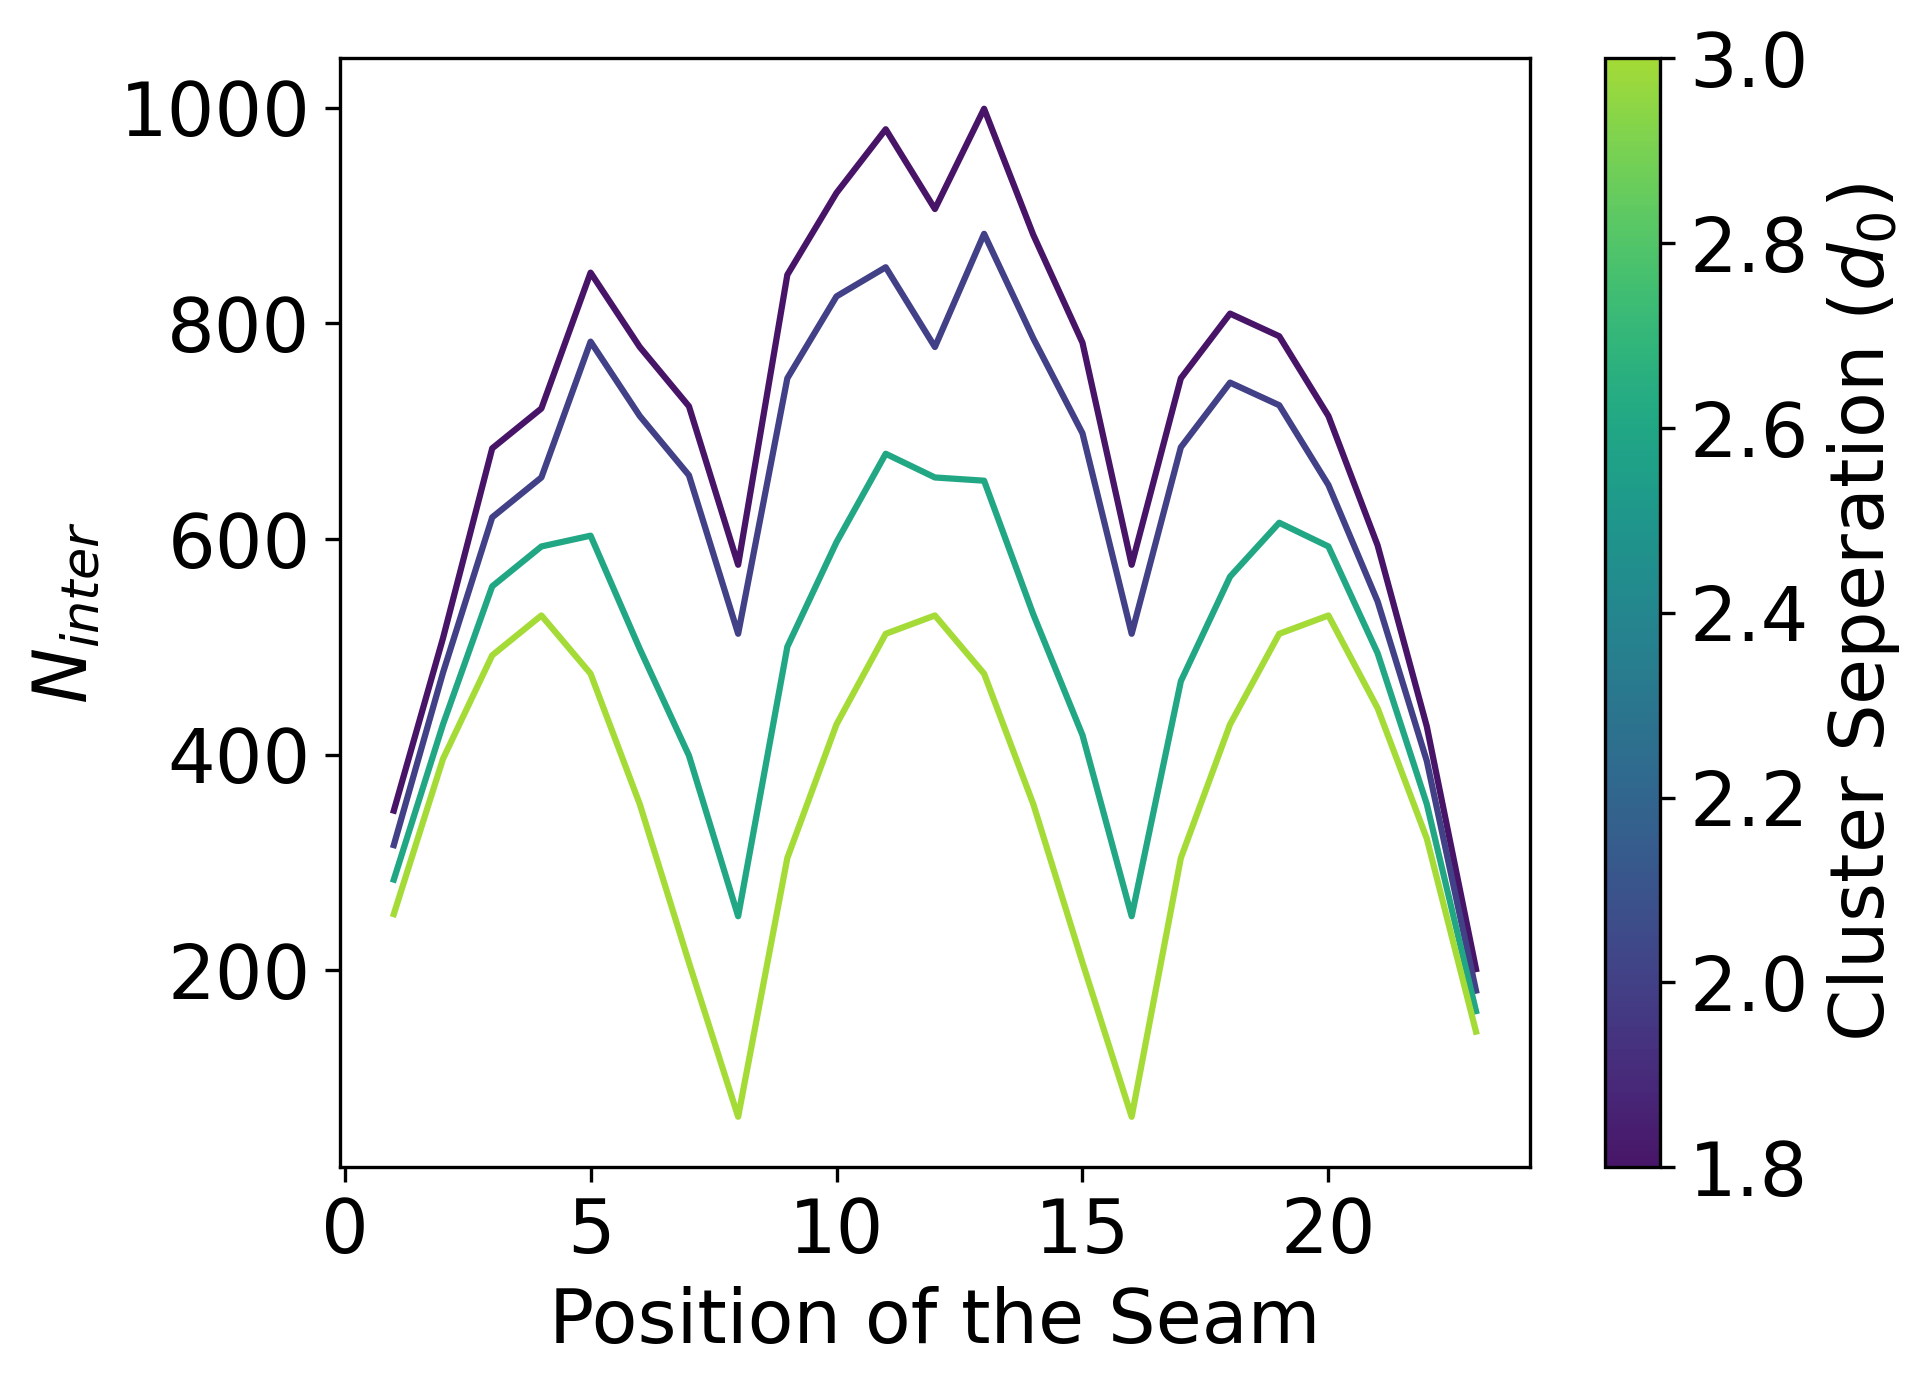

In [28]:
import matplotlib.cm as cm

plt.rcParams.update({'font.size': 18})  # Update font size
distance_lst = [0.8, 1.0, 1.6, 2.0]
norm = plt.Normalize(min(distance_lst)*0.9+1, max(distance_lst)*1.1+1)
N = 24
colormap = plt.cm.viridis
fig, ax = plt.subplots(dpi=300)
epsilon = 1e-3
for distance in distance_lst:
    print(f"cur distance is {distance}")
    uop, all_g = read_uop(distance, read_epsilon, prehead)
    excitations = create_excitation(uop, all_g, epsilon)
    excitations = orbital_reordering(excitations, f_orbs)
    new_circuit = build_custom_USCC(excitations)
    count_lst = []
    for seam in range(N):
        delayed_circuit, count = count_inter_cnot(new_circuit, [seam], ratio)
        count_lst.append(count)
    plt.plot(np.arange(1,N), count_lst[1:], label = f"distance = {distance}", color = colormap(norm((distance+1))))

plt.xlabel("Position of the Seam")
plt.ylabel(r"$N_{inter}$")
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to avoid warnings
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'Cluster Seperation ($d_0$)')
cbar.ax.set_ylim(min(distance_lst) + 1, max(distance_lst) + 1)  # Set colorbar limits
# plt.title(r"$\epsilon = 0.001$")
plt.show()

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_41500\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_41500\1336795324.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for gate, qargs, cargs in circuit.data:
C:\Users\24835\AppData\Local\Temp\ipykernel_41500\3222172864.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
C:\Users\24835\AppData\

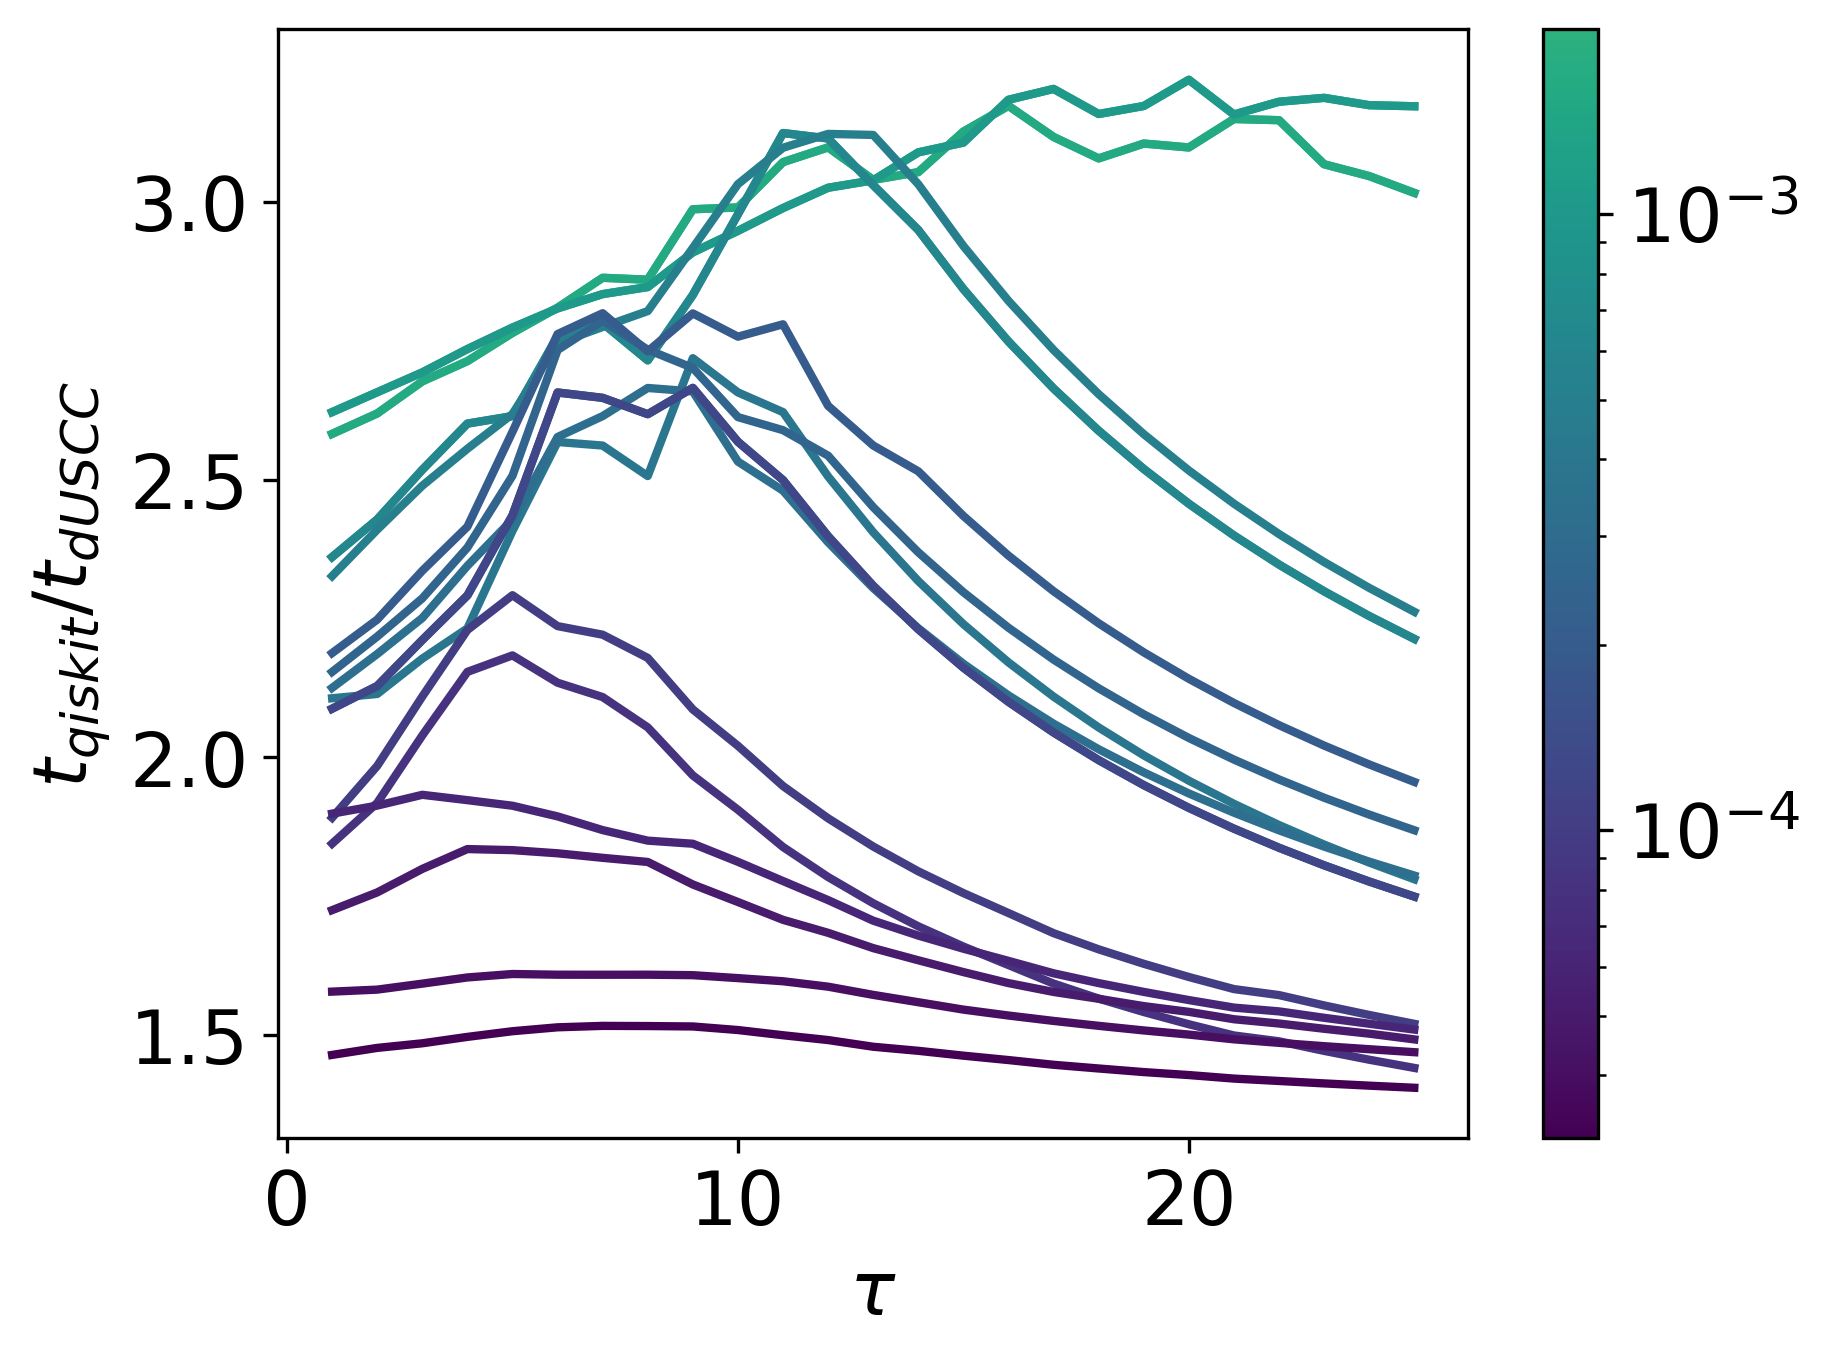

In [ ]:
import matplotlib.colors as mcolors
ratio_lst = np.linspace(1, 25, 25)
distance = 2.0
epsilon_lst = np.linspace(2.7,4.5,19)
epsilon_lst = 10**-(epsilon_lst)
read_epsilon = 1.0
prehead = "../../H_12_cluster/"
uop, all_g = read_uop(distance, read_epsilon, prehead)
seam_lst = [8,16]
fig, ax = plt.subplots(dpi=300)
norm = mcolors.LogNorm(vmin=min(epsilon_lst), vmax=max(epsilon_lst) * 10)
path = f"../../H_12_transition/naive_uscc/inter_transition_{distance+1}/enhanced_epsilon = {read_epsilon}.npy"
directory = os.path.dirname(path)
os.makedirs(directory, exist_ok=True)

for epsilon in epsilon_lst:
    excitations = create_excitation(uop, all_g, epsilon)
    excitations = orbital_reordering(excitations, f_orbs)
    new_circuit = build_custom_USCC(excitations)
    count_lst = []
    color = cmap(norm(epsilon))

    result = np.load(f"../../H_12_transition/double_packed/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy")
    ratio_lst1 = result[0]
    post_gate_lst1 = result[1]/25
    
    for i in range(len(ratio_lst)):
        ratio = ratio_lst[i]
        ratio = int(ratio)
        delayed_circuit, count = count_inter_cnot(new_circuit, seam_lst, ratio)
        count_lst.append(delayed_circuit.depth())
    count_lst = np.array(count_lst)
    ax.plot(ratio_lst, count_lst/post_gate_lst1, label=f"epsilon = {epsilon}", color=color, linewidth=2)
    result = [ratio_lst, count_lst]
    np.save(fc, result)

plt.rcParams.update({'font.size': 18})
# Colorbar setup for main plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$t_{qiskit}/t_{dUSCC}$")
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Epsilon Values')
cbar.ax.set_ylim(min(epsilon_lst), max(epsilon_lst))  # Set colorbar limits
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Final adjustments and showing the plot
  # Update font size
plt.show()

In [25]:
distance = 2.0
epsilon_lst = np.linspace(2.7,4.5,19)
epsilon_lst = 10**-(epsilon_lst)
data = np.zeros([len(epsilon_lst), len(ratio_lst)])
for i in range(len(epsilon_lst)):
    epsilon = epsilon_lst[i]
    result = np.load(f"../../H_12_transition/double_packed/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy")
    ratio_lst1 = result[0]
    post_gate_lst1 = result[1]/25
    initial_gate = post_gate_lst1[0]
    qiskit_result = np.load(f"../../H_12_transition/naive_uscc/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy")
    qiskit_gate_lst1 = qiskit_result[1]
    qiskit_gate_lst1 = np.array(qiskit_gate_lst1)
    for j in range(len(ratio_lst)):
        data[i,j] = qiskit_gate_lst1[j]/post_gate_lst1[j]

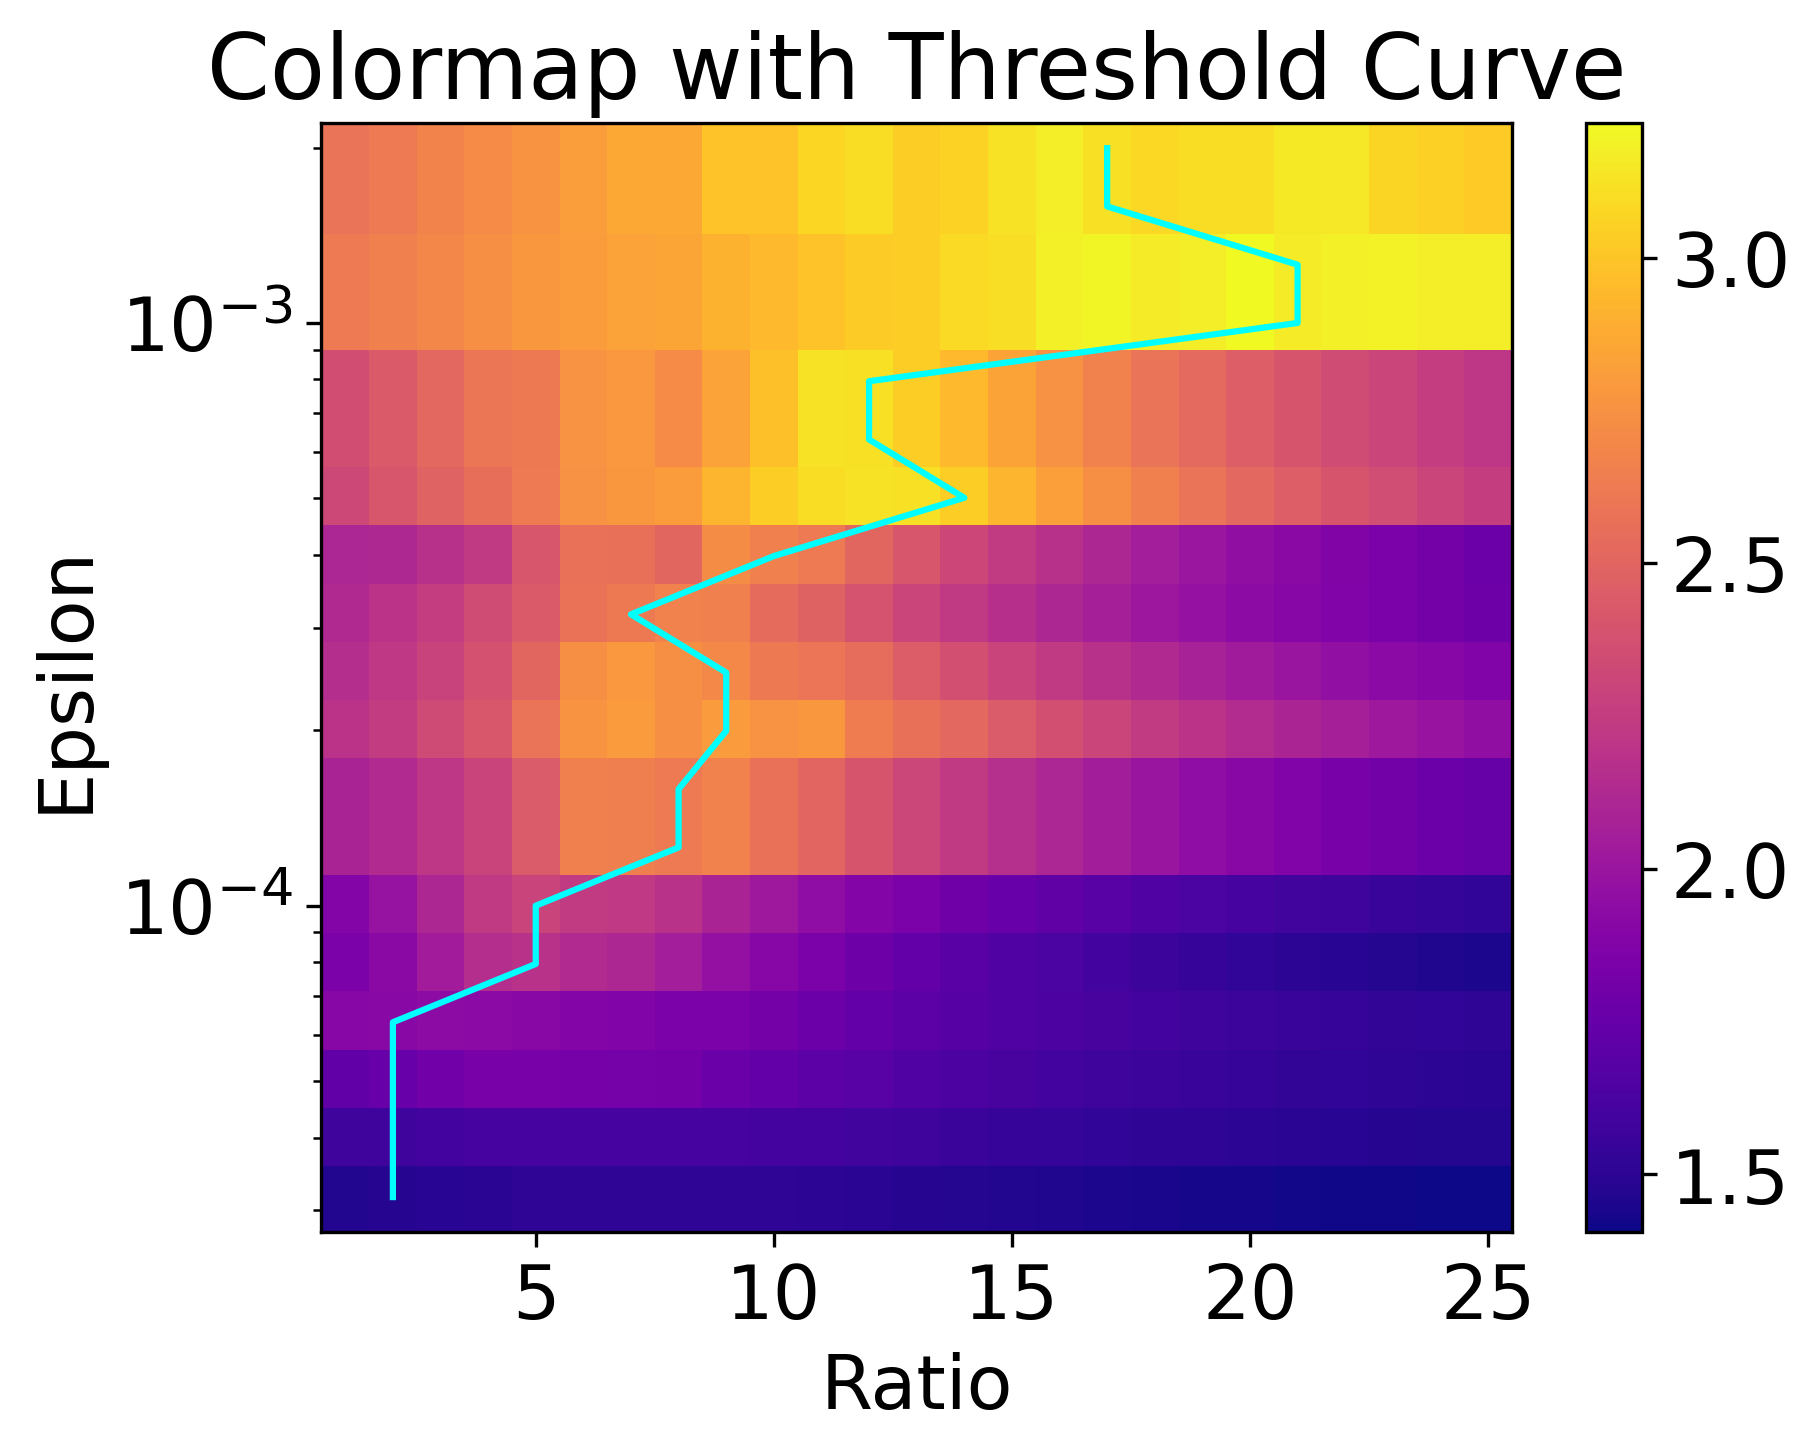

[[2.58249497 2.61923848 2.67706237 2.71342685 2.76429288 2.80961924
  2.86345382 2.85996055 2.98682877 2.99001996 3.0716448  3.09819639
  3.03969022 3.05363985 3.12657005 3.17294686 3.11693171 3.07832423
  3.10507246 3.09803922 3.14924039 3.14713656 3.06779661 3.04651163
  3.01623377]
 [2.58249497 2.61923848 2.67706237 2.71342685 2.76429288 2.80961924
  2.86345382 2.85996055 2.98682877 2.99001996 3.0716448  3.09819639
  3.03969022 3.05363985 3.12657005 3.17294686 3.11693171 3.07832423
  3.10507246 3.09803922 3.14924039 3.14713656 3.06779661 3.04651163
  3.01623377]
 [2.621673   2.65741445 2.69315589 2.7351372  2.77383677 2.80830793
  2.83409263 2.84676205 2.90919453 2.94790875 2.98895659 3.02551409
  3.03892668 3.08921792 3.10679245 3.1838685  3.20342205 3.15826538
  3.17268041 3.21988174 3.15734767 3.18035714 3.18732295 3.17411026
  3.17218772]
 [2.621673   2.65741445 2.69315589 2.7351372  2.77383677 2.80830793
  2.83409263 2.84676205 2.90919453 2.94790875 2.98895659 3.02551409
  3.03

In [34]:
import matplotlib.pyplot as plt
import numpy as np

ratio_lst = np.linspace(1, 25, 25)
distance = 2.0
epsilon_lst = np.linspace(2.7,4.5,19)
epsilon_lst = 10**-(epsilon_lst)

fig, ax = plt.subplots(dpi=300)

# Create meshgrid
x, y = np.meshgrid(ratio_lst, epsilon_lst)

# Plot colormap
c = ax.pcolormesh(x, y, data, cmap='plasma', shading='auto')
# ax.hlines(10**(-4.2),xmin=ratio_lst.min(), xmax=ratio_lst.max())
ax.set_yscale('log')

# Add colorbar
cb = fig.colorbar(c, ax=ax)
# cb.set_ticks([1, 3])

# Plot curve: threshold is an array of same length as epsilon_lst
# So we treat epsilon_lst as y-axis, threshold as x-values
# ax.plot(threshold2, epsilon_lst, color='cyan', label='$t/t_0 = 1.1$')
threshold = [17, 17, 21, 21, 12, 12, 14, 10,  7,  9,  9,  8,  8,  5,  5,  2,  2,  2,
2]
ax.plot(threshold, epsilon_lst, color='cyan', label=r'$t/t_0 = 1.05$')

# Labels and title
ax.set_xlabel('Ratio')
ax.set_ylabel('Epsilon')
ax.set_title('Colormap with Threshold Curve')

plt.show()
print(data)

Missing module: mrh.exploratory.unitary_cc.uccsd_sym1, substituting with DummyMRH


C:\Users\24835\AppData\Local\Temp\ipykernel_41500\830347428.py:42: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cbar.ax.set_ylim(min(epsilon_lst), max(epsilon_lst))  # Set colorbar limits


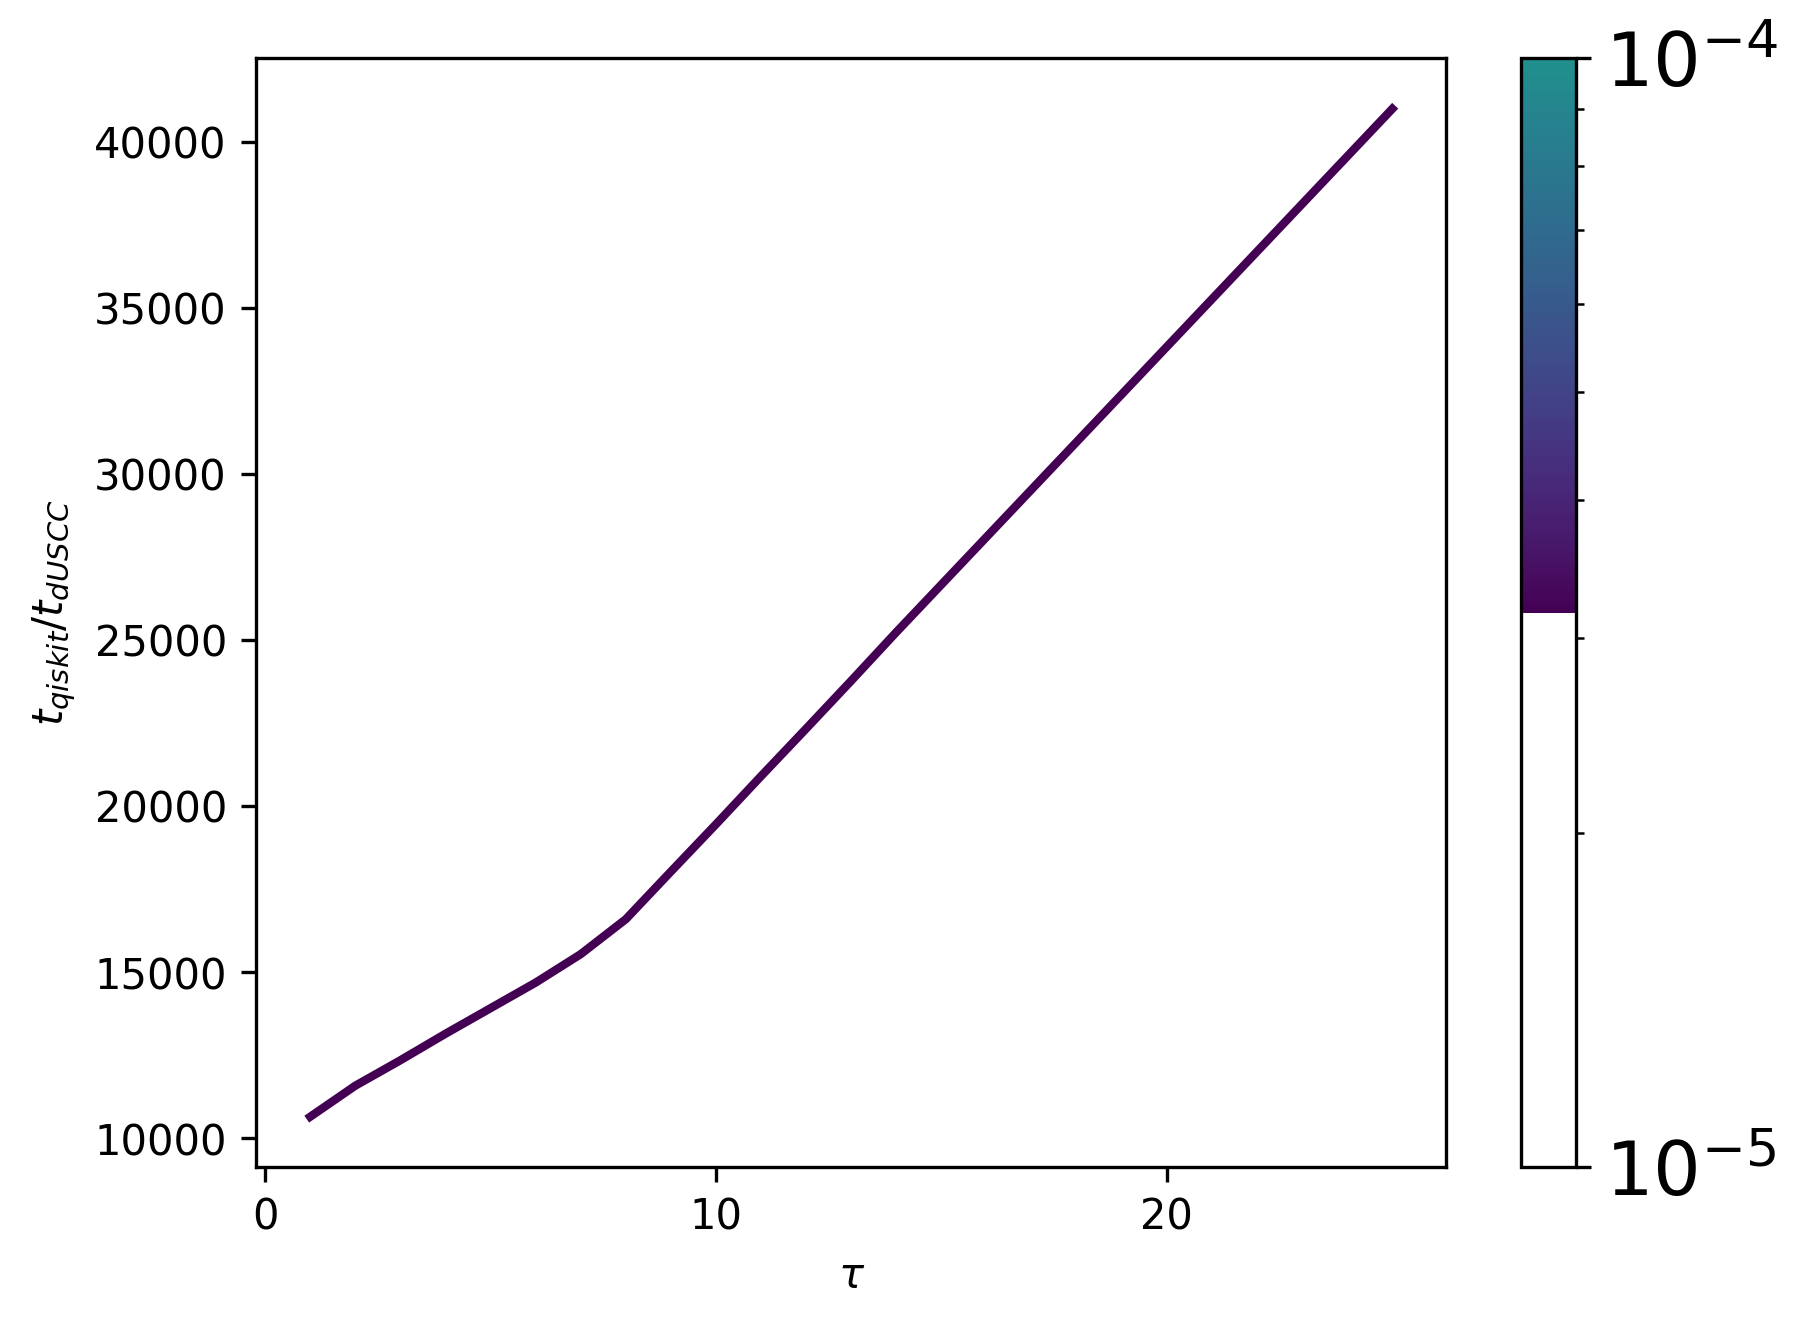

In [8]:
import matplotlib.colors as mcolors
ratio_lst = np.linspace(1, 25, 25)
distance = 3.0
epsilon_lst = np.linspace(3.2,4.5,14)
epsilon_lst = 10**-(epsilon_lst)
epsilon_lst = epsilon_lst[13:14]
prehead = "../../H_12_cluster/"
uop, all_g = read_uop(distance, read_epsilon, prehead)
seam_lst = [8,16]
fig, ax = plt.subplots(dpi=300)
cmap = plt.cm.viridis

norm = mcolors.LogNorm(vmin=min(epsilon_lst), vmax=max(epsilon_lst) * 10)
path = f"../../H_12_transition/naive_uscc/inter_transition_{distance+1}/enhanced_epsilon = {read_epsilon}.npy"
directory = os.path.dirname(path)
os.makedirs(directory, exist_ok=True)

for epsilon in epsilon_lst:

    count_lst = []

    result = np.load(f"../../H_12_transition/naive_uscc/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy")
    ratio_lst1, count_lst = result
    color = cmap(norm(epsilon))

    result = np.load(f"../../H_12_transition/double_packed/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy")
    ratio_lst1 = result[0]
    post_gate_lst1 = result[1]/25
    count_lst = np.array(count_lst)
    ax.plot(ratio_lst, post_gate_lst1, label=f"epsilon = {epsilon}", color=color, linewidth=2)
    result = [ratio_lst, count_lst]
    np.save(f"../../H_12_transition/naive_uscc/inter_transition_{distance+1}/enhanced_epsilon = {epsilon:.7f}.npy", result)

plt.rcParams.update({'font.size': 18})
# Colorbar setup for main plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$t_{qiskit}/t_{dUSCC}$")
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Epsilon Values')
cbar.ax.set_ylim(min(epsilon_lst), max(epsilon_lst))  # Set colorbar limits
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Final adjustments and showing the plot
  # Update font size
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
